In [650]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [651]:
# for this demo we just keep one-third of the data
data = pd.read_csv("https://datahack2020dataset.s3.us-east-2.amazonaws.com/OfficialCompetitionDataset.csv")
data.pop('Unnamed: 0')

print(f'data dimensions: {data.shape}')

data dimensions: (26504, 25)


In [652]:
data.head()

,name,album,artist,auditory,beats_per_measure,beats_per_min,concert_probability,critic,critic_rating,danceability,hotness,hype,instrumentalness,length_minutes,lyricism,major/minor,nplays,positivity,review,reviewer_type,song_debut,styles,tone,volume,vulgar
0,A Forgotten Chapter In The History Of Ideas,VI,the fucking champs,0.24030,4.0,175.934,32.00,adam moerder,70.0,1.216527,1.0,0.627541,1.060468,388200,8.0,major,5026,-0.676431,\r\n What an opportune time for a Fucking C...,NaN,2007-04-24,rock,C#,0.794281,NOT VULGAR
1,I Would Like to Write a Song That...,Muted,alias,0.02061,4.0,97.017,24.40,william morris,60.0,1.382647,0.6,0.575489,1.256408,252560,7.0,major,7823,-0.684217,"Listen up, kids; it's time for me to play like...",NaN,2003-10-28,"electronic, rock",D,0.760773,NOT VULGAR
2,Awake On A Train,Yesterday Was Dramatic – Today Is OK,mm,0.88200,4.0,110.005,9.99,matt lemay,91.0,1.469614,4.0,0.498955,1.125781,563253,3.0,major,161260,0.016498,"Surprises are the best. Once, when I was in ki...",contributor,2005-10-04,"electronic, rock",F,0.738168,NOT VULGAR
3,Dress,Sylvan Esso,sylvan esso,2.57100,4.0,139.955,10.50,ian cohen,62.0,1.958150,8.8,0.456158,-0.844109,229840,9.0,minor,14379524,-0.964502,There are bands that arrive fully formed with ...,contributor,2014-05-13,pop/r&b,F,0.824472,NOT VULGAR
4,People Die,Travistan,travis morrison,0.22140,3.0,144.033,35.00,chris dahlen,0.0,2.377382,0.4,0.400788,-0.844077,262627,8.0,minor,4549,1.857820,Travis Morrison got his ass kicked. He tells ...,NaN,2004,pop/r&b,F,0.777020,NOT VULGAR


Helper Functions and Symbols

In [653]:
# Symbols for frequently used strings

TIME = 'song_debut'
PLAYS = 'nplays'
VULGAR = 'vulgar'
song_qualities = ['auditory', 'beats_per_min', 'danceability', 'hype', 'instrumentalness', 'lyricism', 'positivity', 'volume', VULGAR, PLAYS, TIME]

def filter_cols(df, cols):
  return df[cols]

def extract_year_from_date(df):
  df = df.copy()
  df[TIME] = df[TIME].str.slice(0,4)
  df[TIME] = df[TIME].astype('int64')
  return df

def extract_year_from_categories(df):
  df = df.copy()
  df[TIME] = df[TIME].astype(str)
  df[TIME] = df[TIME].str.slice(1,5).astype(int)
  return df

def normalize_cols(df, cols):
  df = df.copy()
  scaler = MinMaxScaler()
  for col in df:
    if col == TIME or col == PLAYS or col == VULGAR:
      continue
    df.loc[:, col] = scaler.fit_transform(df[[col]])
  df.replace('VULGAR', 1, inplace=True)
  df.replace('NOT VULGAR', 0, inplace=True)
  # df.replace('VULGAR', 1)
  # df.replace('NOT VULGAR', 0)
  df = extract_year_from_date(df)
  return df

def group_by_year(df):
  df = df.copy()

  for i in range(1960,2000,10):
    df.loc[(df[TIME] >= i) & (df[TIME] < i+10),TIME] = i

  df.loc[(df[TIME] >= 2016),TIME] = 2016
  return df

# def group_by_year(df, year_bins):

  # for i, year in enumerate(year_bins[:-1]):
  #   df.loc[(df[TIME] >= year) & (data[TIME] < year_bins[i + 1]),TIME] = year
  # return df

  # df[TIME] = pd.cut(df[TIME], bins=year_bins, right=False, labels=year_bins[:-1])
  # df[TIME] = df[TIME].astype(int)

  # return df

def plot_features(df, x_name, y_name):
  plt.figure(figsize=(30,10))
  ax = sns.lineplot(x=df[x_name], y=df[y_name], data=df, hue='popular')
  # ax.set(ylim=(0,1))

def plot_all_features_by_time(df):
  for col in df:
    if col == TIME or col == PLAYS:
      continue
    plot_features(df, TIME, col)

def popularize_in_place(df):
  grouped = df.groupby(TIME)
  thresholds = grouped.quantile(q = 0.90)[PLAYS].values
  years = np.sort(df[TIME].unique())
  df['popular'] = 0

  for year, th in zip(years, thresholds):
    df.loc[(df[TIME] == year) & (df[PLAYS] >= th),'popular'] = 1

In [654]:
# year_bins = np.arange(1960, 2000, 10)
# year_bins = np.append(year_bins, np.arange(2000, 2017, 1))
# year_bins = np.append(year_bins, [2017, 2021])

Create a dataframe with song qualities, grouped by year bins, where the debut date is set to the first year of the bin.
The year bins were every decade before 2000 (excluding 1952), every year from 2000-2016, and one bin for everything 2016 and beyond.

In [655]:
data_features = filter_cols(data, song_qualities)
data_features = normalize_cols(data_features, song_qualities)
data_features = group_by_year(data_features)

In [656]:
data_features = data_features[data_features[TIME] != 1952]

In [657]:
data_features.dtypes

auditory            float64
beats_per_min       float64
danceability        float64
hype                float64
instrumentalness    float64
lyricism            float64
positivity          float64
volume              float64
vulgar                int64
nplays                int64
song_debut            int64
dtype: object

Create a column called 'popular' which is set to 1 if the song is in the top 10% of its bin.

In [658]:
popularize_in_place(data_features)

In [659]:
data_features['popular'].value_counts()

0    23835
1     2660
Name: popular, dtype: int64

Plot all the song qualities against the year bins, separated by the popularity in that bin.

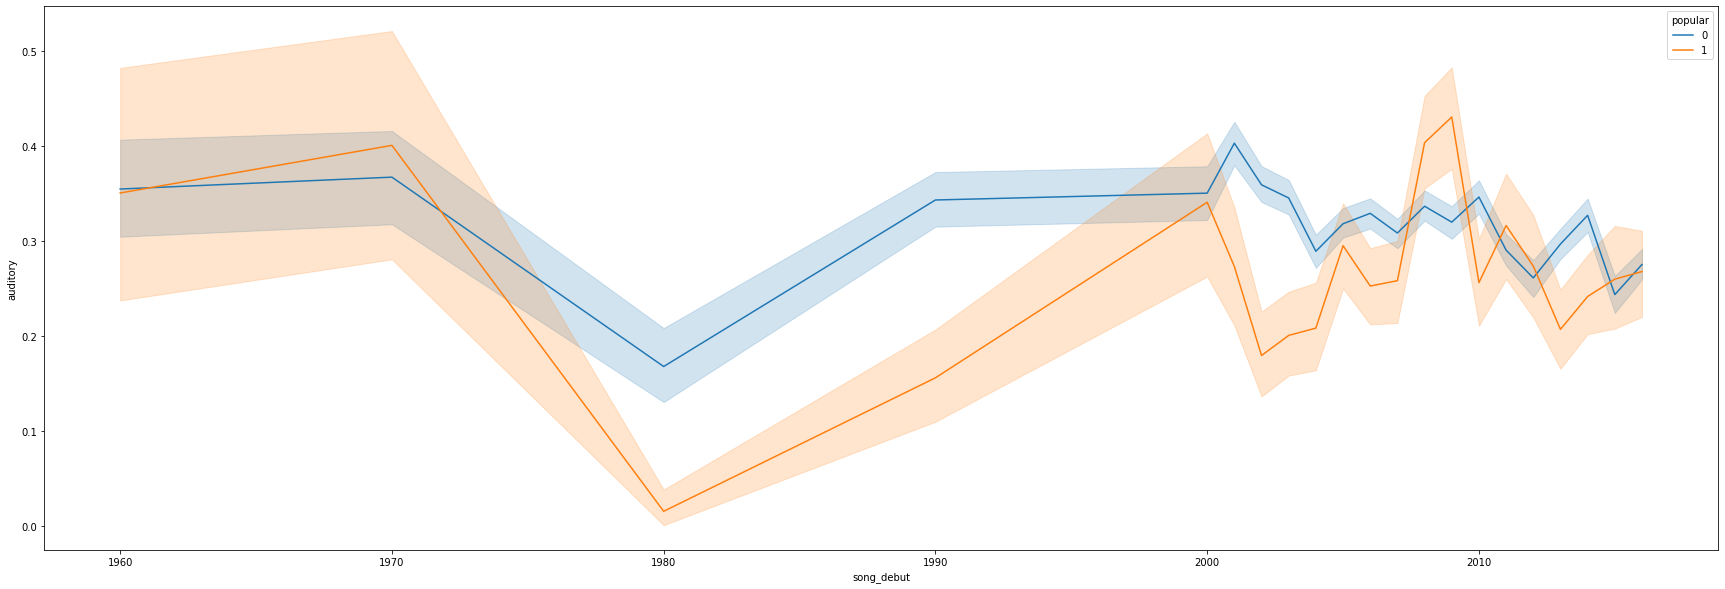

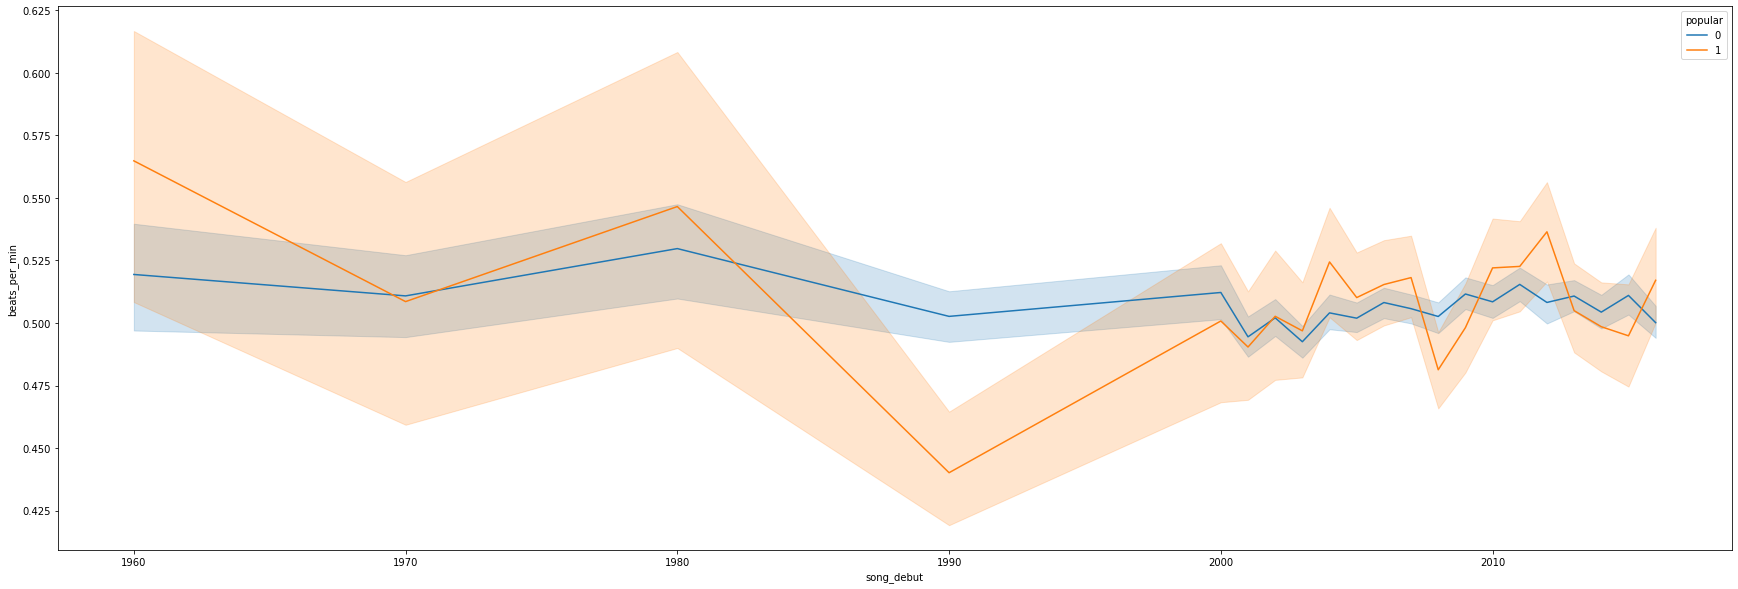

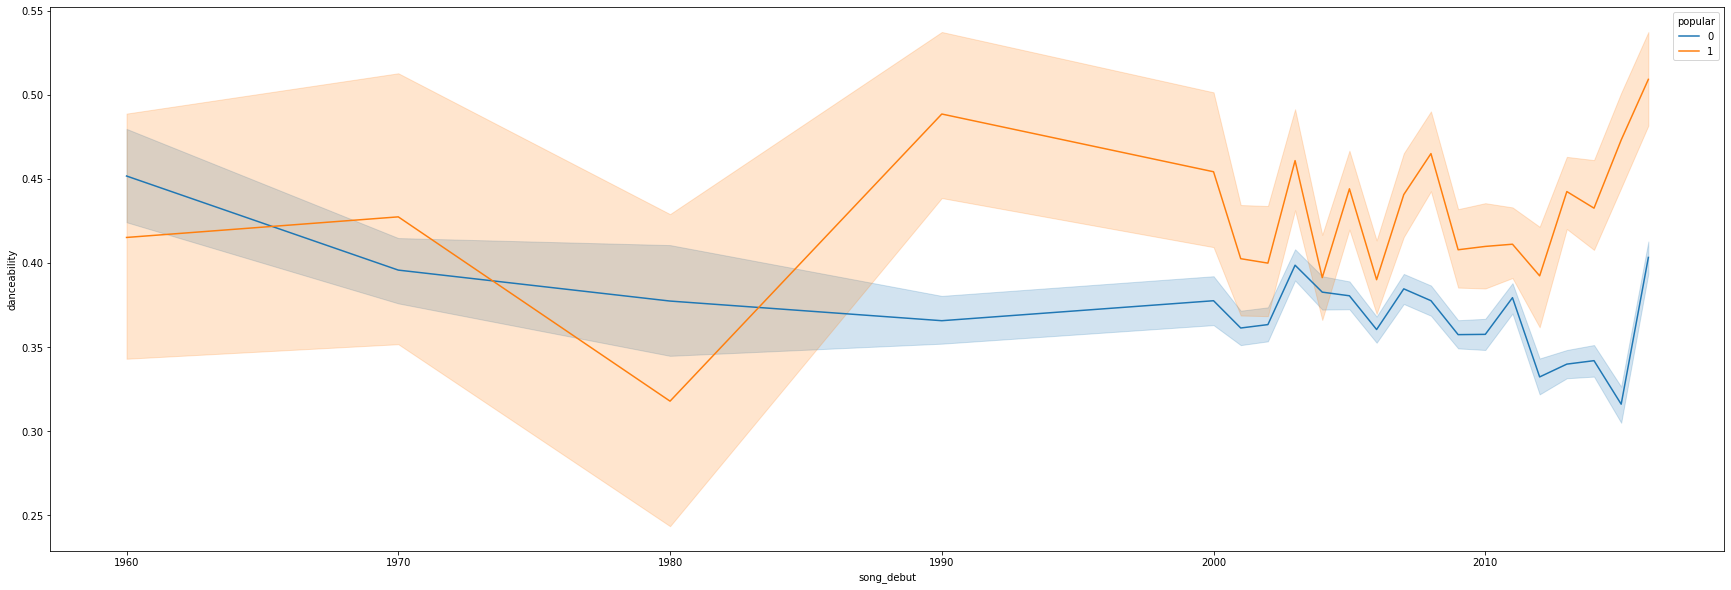

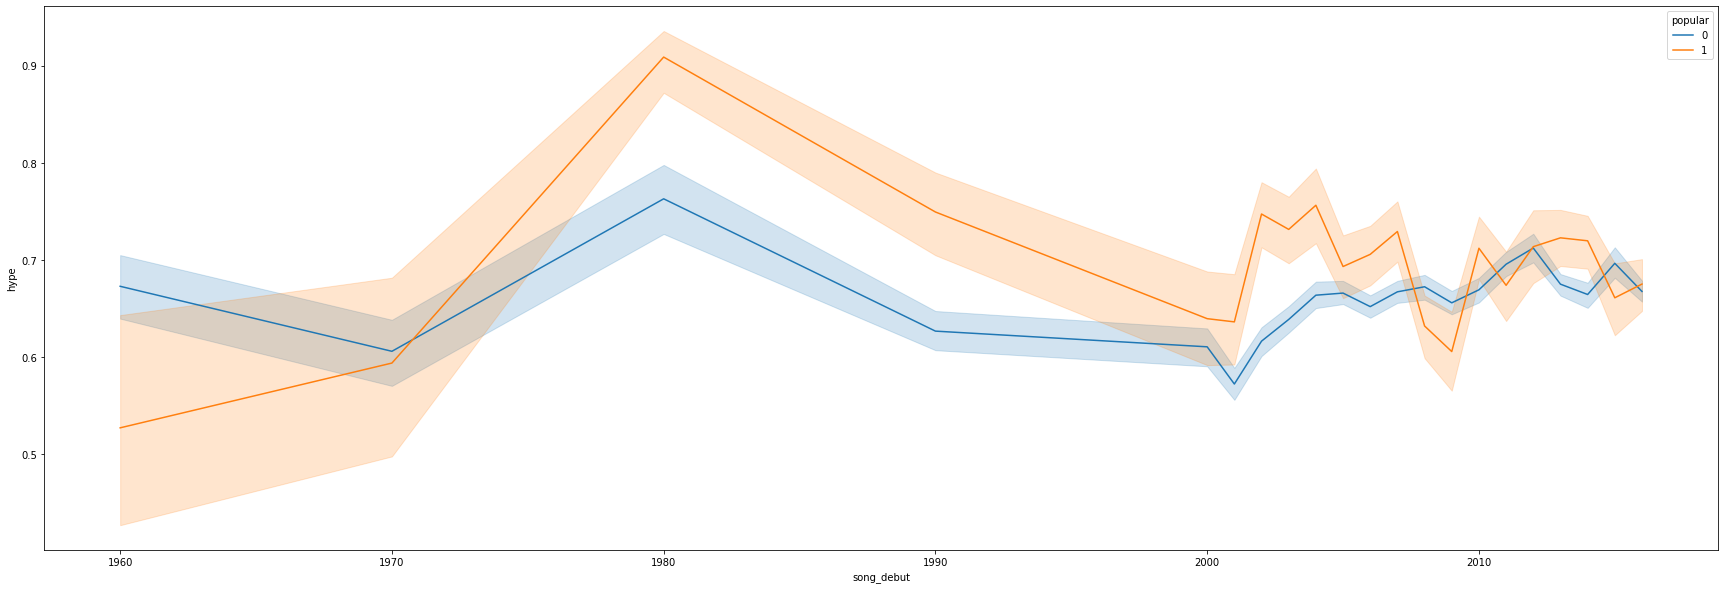

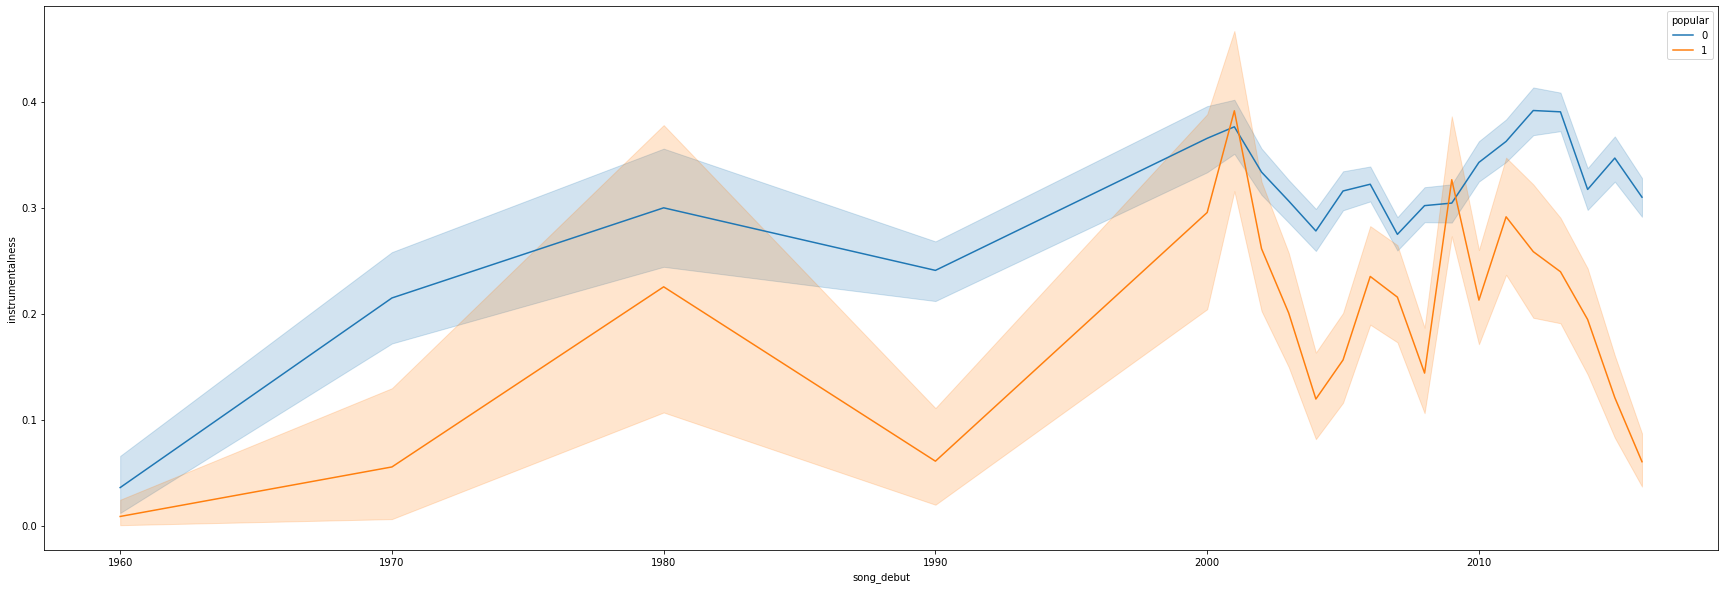

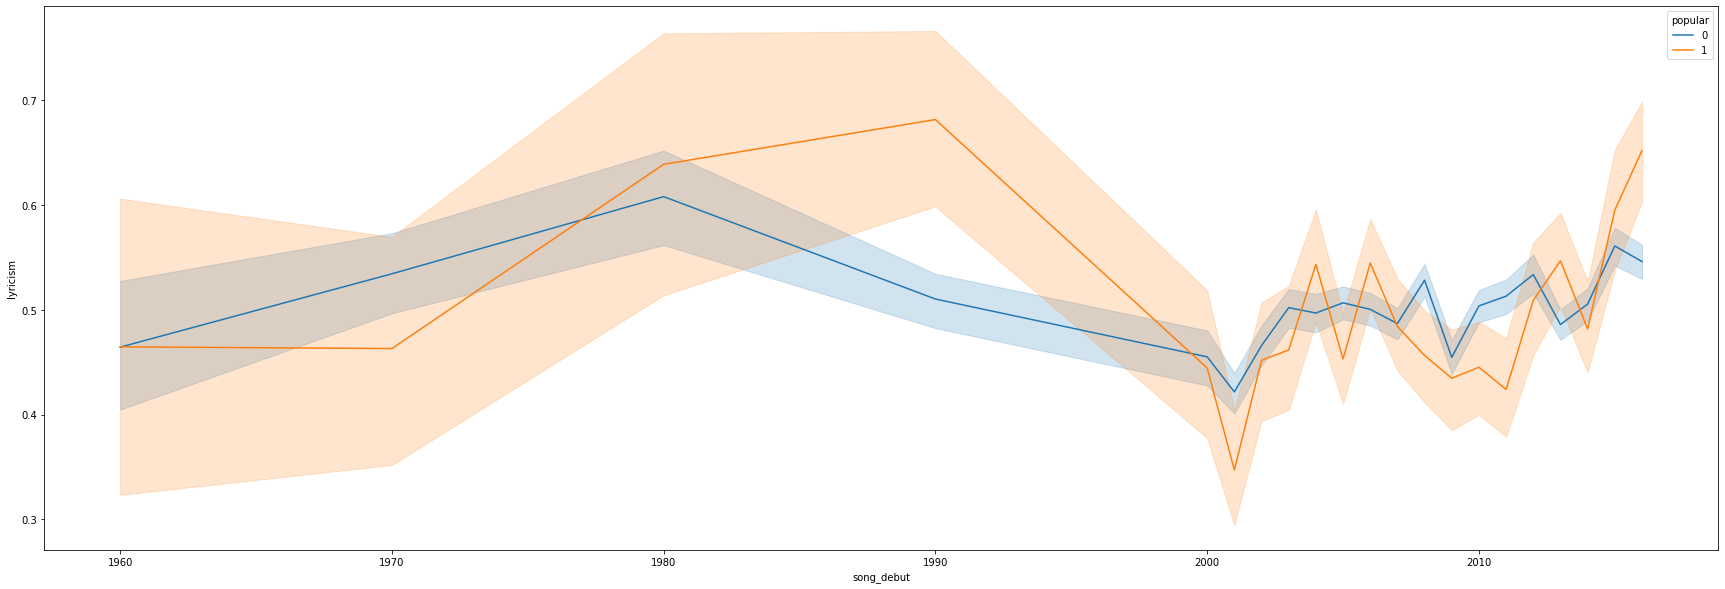

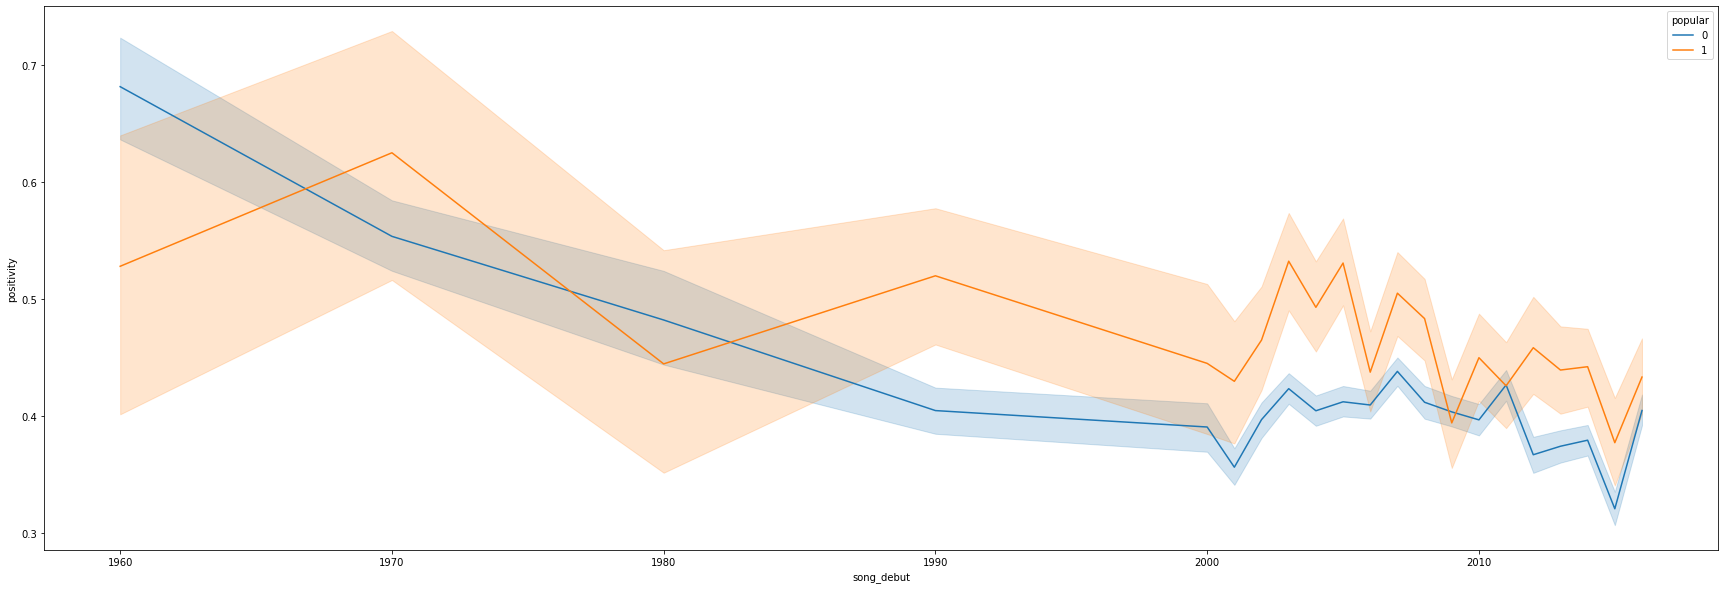

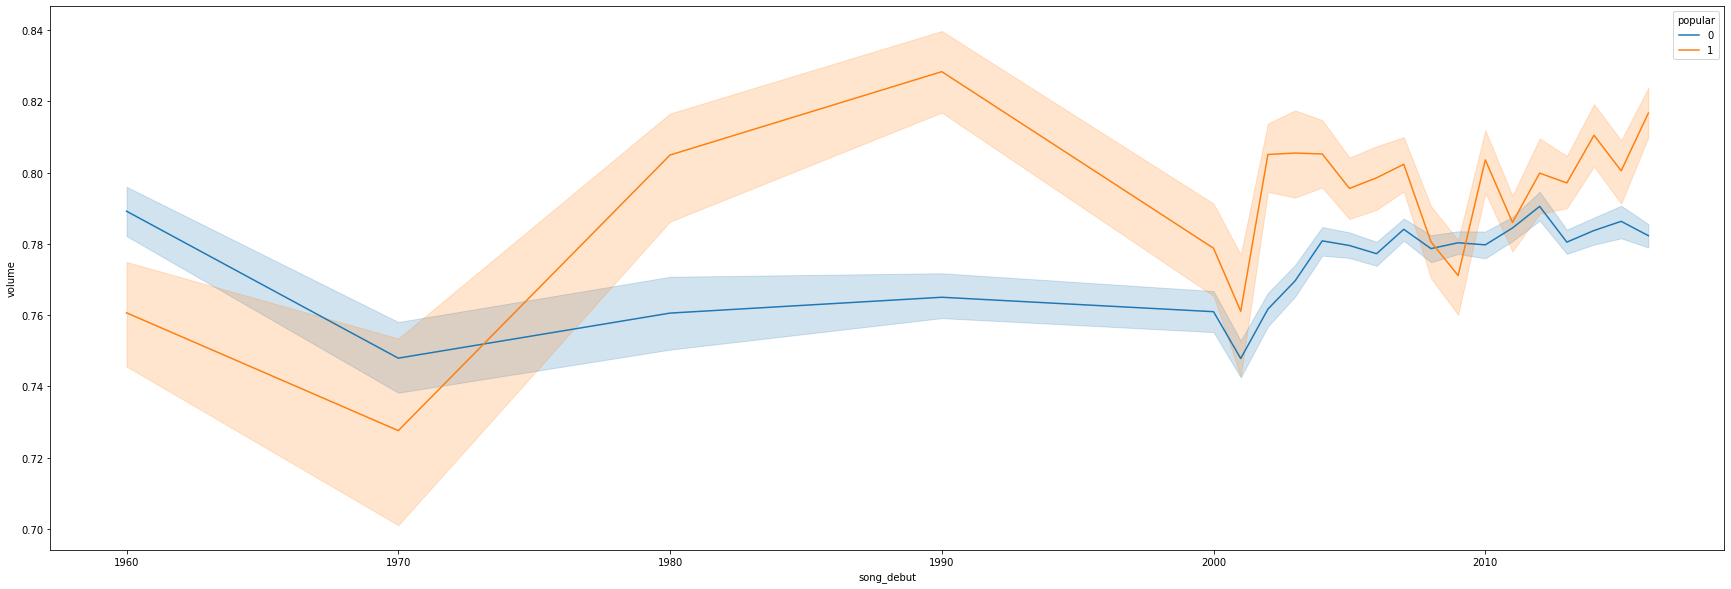

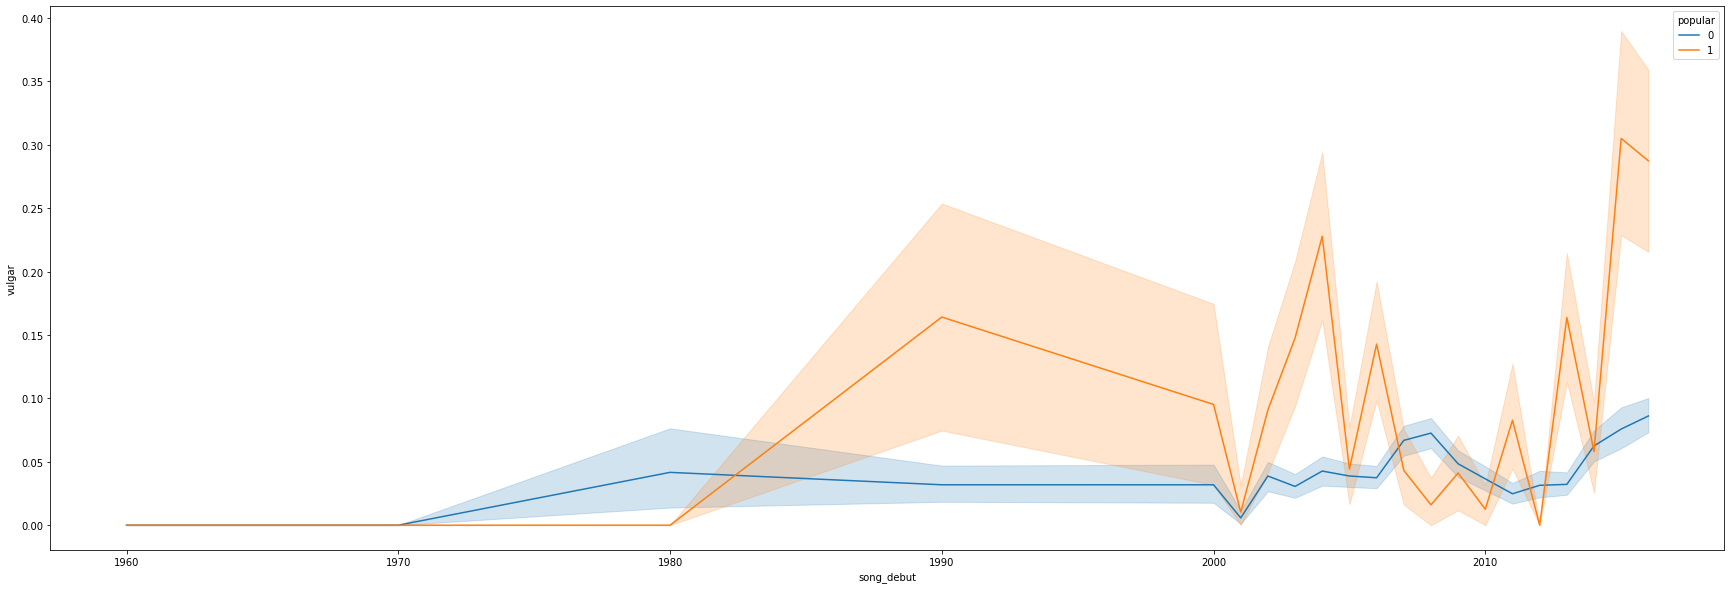

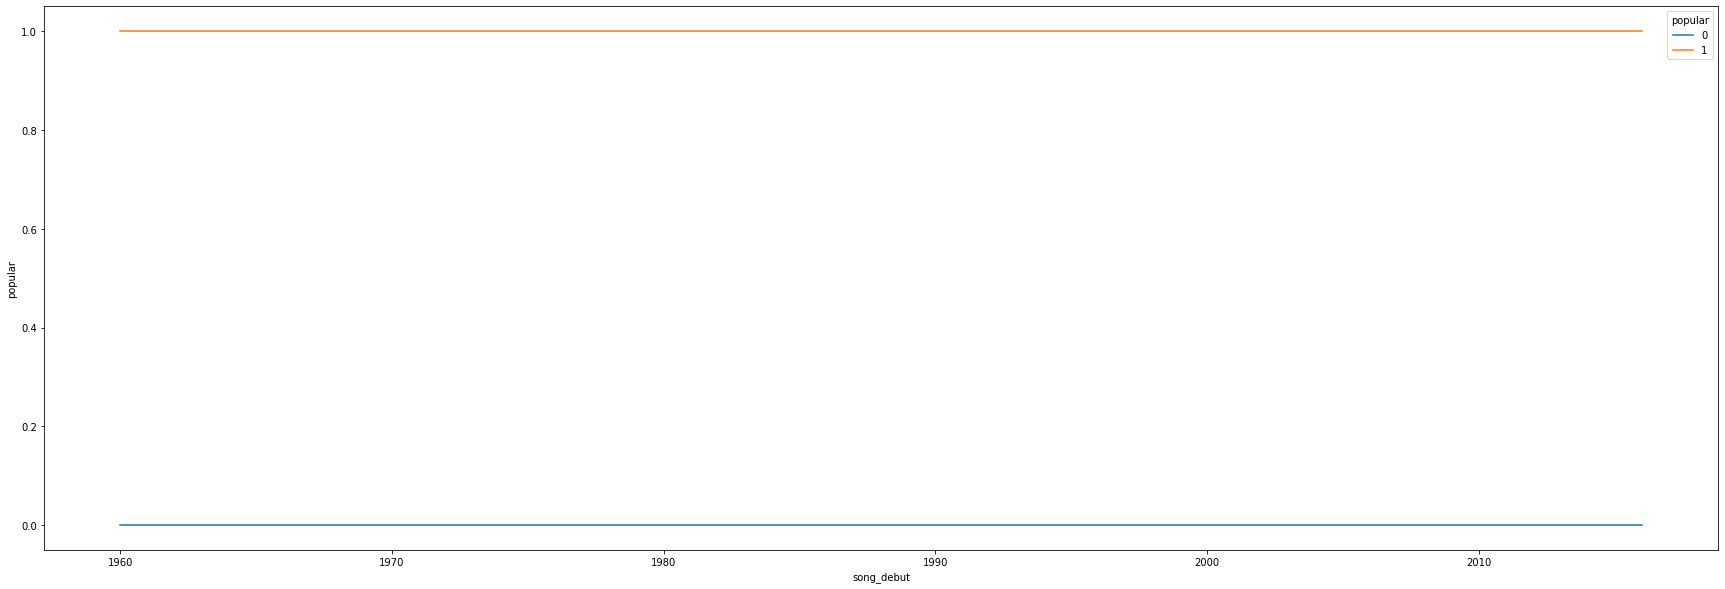

In [660]:
plot_all_features_by_time(data_features)

Repeat the above procedure, but for the top 5 most occurring styles across the dataset.

In [661]:
data_styles = filter_cols(data, ['styles', PLAYS, TIME])
data_styles = extract_year_from_date(data_styles)
data_styles = group_by_year(data_styles)
popularize_in_place(data_styles)

In [662]:
top_styles = data_styles['styles'].value_counts()[:5].index.to_list()

In [663]:
dropped_styles = data_styles[data_styles.styles.isin(top_styles)]

In [664]:
one_hot = pd.get_dummies(dropped_styles, columns=['styles']).drop(PLAYS, axis=1)
one_hot

,song_debut,popular,styles_electronic,"styles_electronic, rock","styles_experimental, rock",styles_pop/r&b,styles_rock
0,2007,0,0,0,0,0,1
1,2003,0,0,1,0,0,0
2,2005,0,0,1,0,0,0
3,2014,1,0,0,0,1,0
4,2004,0,0,0,0,1,0
...,...,...,...,...,...,...,...
26498,2010,0,0,0,1,0,0
26499,2002,1,0,1,0,0,0
26500,2014,0,0,1,0,0,0
26501,2005,1,0,0,0,0,1


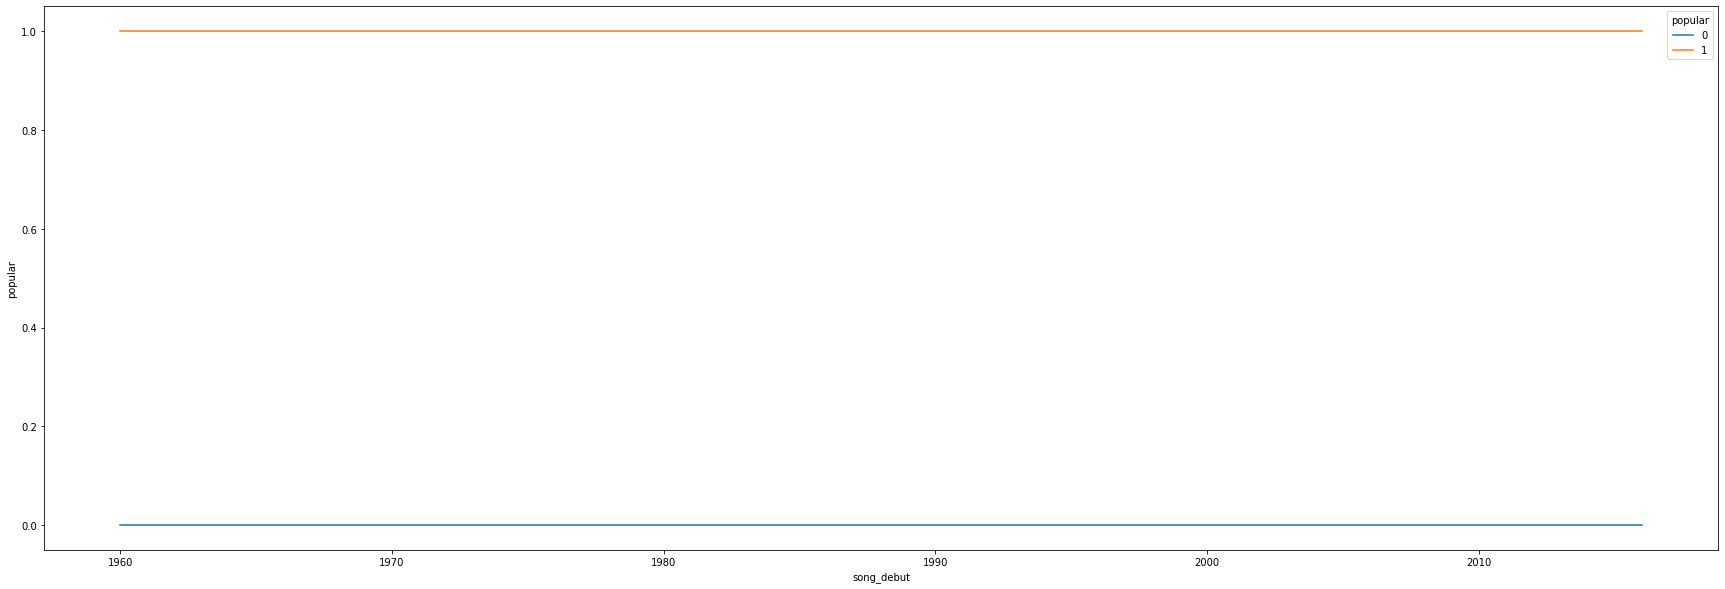

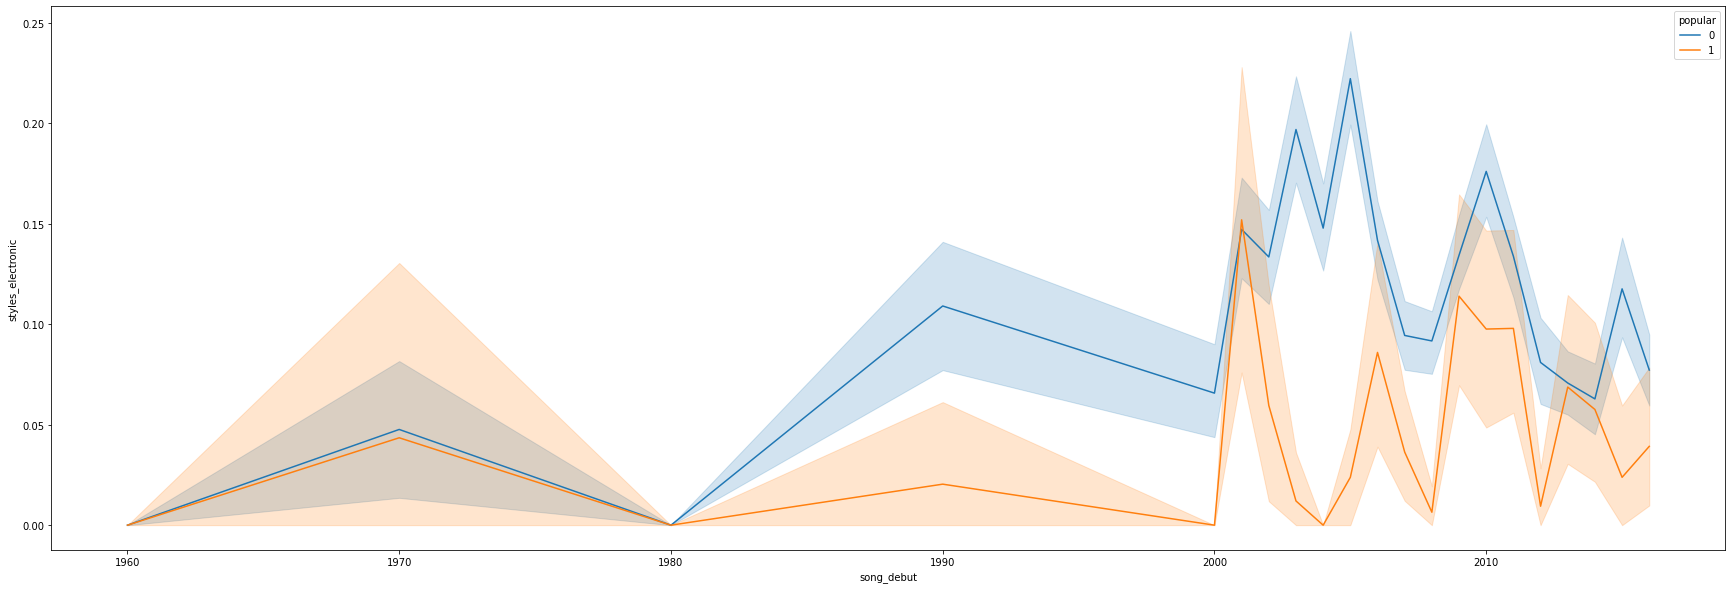

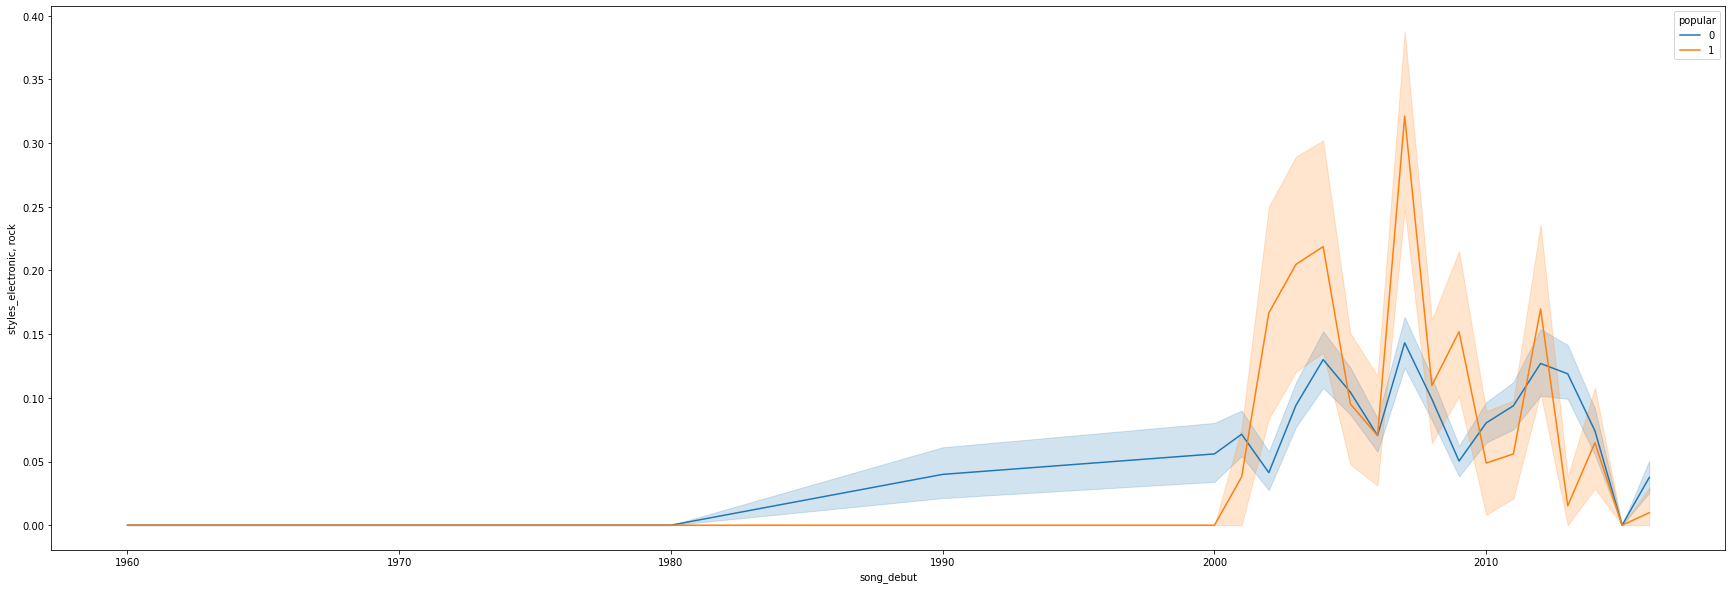

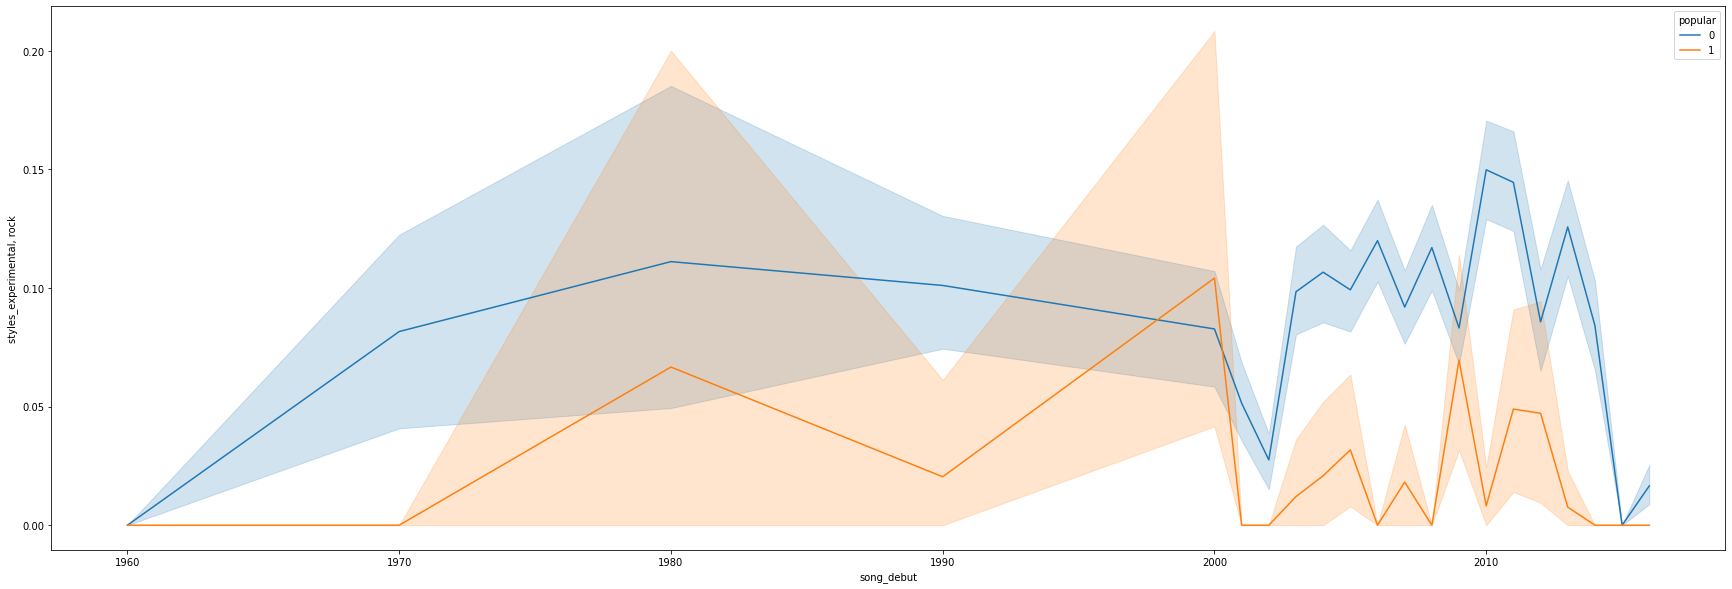

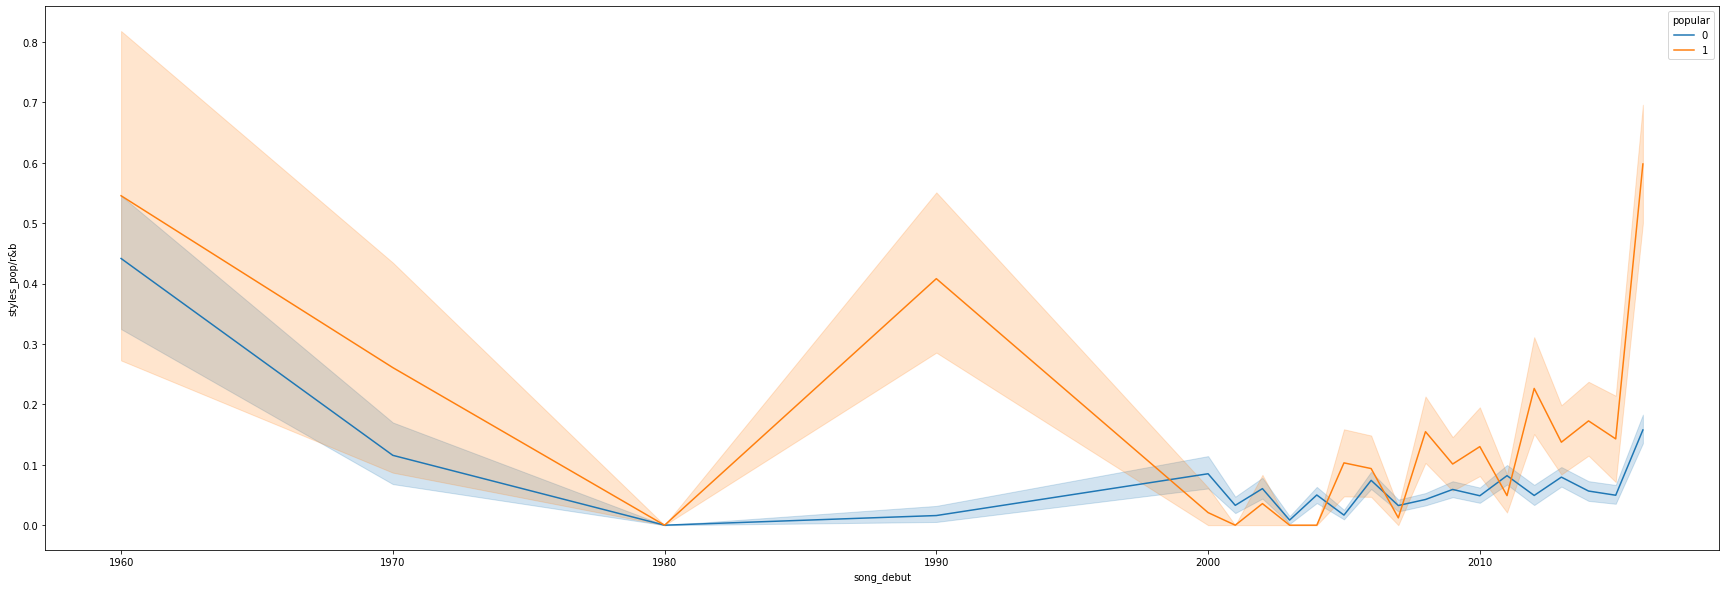

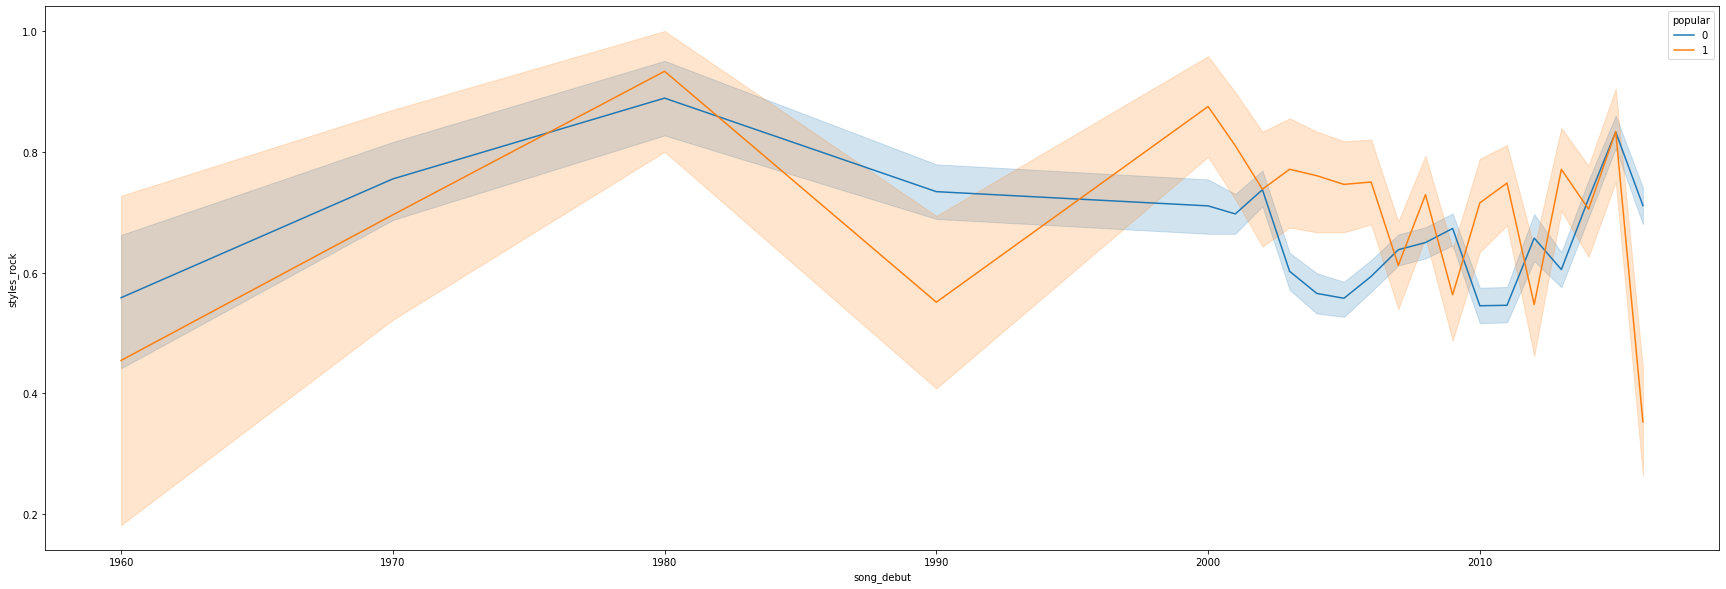

In [649]:
plot_all_features_by_time(one_hot)